### Contents

__Preparing data__
* [Packages](#packages)
* [Functions](#prepfunctions)
* [WT-Parameters](#WT_parameters)
* [preparing Sequences for Filtering](#dataPrep)

__Filtering__
* [Functions](#FilterPckgs)
* [Loop](#Loop)
* [Stem](#Stem)
* [Filtering & Clustering](#filtering)

<a id='packages'></a>

In [40]:
## Packages needed to run the data clean up
using DataFrames
using CSV
using FASTX
using BioAlignments
using BioSequences
using Random
using StatsBase
using StatsPlots
using Combinatorics
using ViennaRNA
using Unitful
using Clustering
using PlotRNA
using DelimitedFiles

<a id='prepfunctions'></a>

In [2]:
## Loading the folding parameters for ViennaRNA
ViennaRNA.params_load_RNA_Langdon2018()

In [41]:
# Load FASTA file as an Array of String
function load_fasta_file(file_name::String)
    R0 = []
    reader = FASTA.Reader(open(file_name, "r"))
    for record in reader
        push!(R0, convert(String, FASTA.sequence(record)))
    end
    close(reader)
    return R0
end

# Uses string patterns to isolate LoopI relevant sequences
function isolate_hairpin(File::String, upstream::String, downstream::String)
    full_seq = []
    all_seq = load_fasta_file(File)

    for n = 1:size(all_seq, 1)
        if occursin(upstream, all_seq[n]) && occursin(downstream, all_seq[n]) # looks for sequences that have both sequences
            edge1 = findfirst(upstream, all_seq[n])[end] # finds the beginning of stem 1
            edge2 = findfirst(downstream, all_seq[n])[1] # finds the end of stem 1
            # the processing above must always be checked to ensure single base duplication or
            # deletion is not being accidentally introduced 
    
            new_seq = all_seq[n][edge1:edge2]
            if new_seq != ""
                push!(full_seq, new_seq) # pushes non-empty sequences into a set
            end
        end
    end

    return full_seq
end    

# used to convert individual NGS reads into a table containing the counts of individual sequences
function instance_to_count(library, wild_type)
    # Converts the data to a dictionary to allow de-duplication
    NGS_processing = Dict{String, Int64}()
    NGS_clean = DataFrame([[],[],[],[], []],["Sequence_number", "LoopI", "Loop_length", "Count", "WT"])

    for i = 1: size(library, 1) # de-duplication process
        if haskey(NGS_processing, library[i])
            NGS_processing[library[i]] += 1
        else
            NGS_processing[library[i]] = 1
        end
    end

    # Remaps the dictionary to a DataFrame for subsequent analysis
    for (key, value) ∈ NGS_processing   # converts dictionary to DataFrame
        entry = DataFrame([[0], [key], [length(key)], [value], ["false"]], ["Sequence_number", "LoopI", "Loop_length", "Count", "WT"])
        append!(NGS_clean, entry)
    end
    
    sort!(NGS_clean, :Count, rev=true)
    
    ## Identifies the WT sequence
    for n = 1:size(NGS_clean, 1)
    NGS_clean.Sequence_number[n] = n
        if NGS_clean.LoopI[n] == wild_type
            NGS_clean.WT[n] = "WT"
        end
    end
    
    return NGS_clean
end 

# Generates all possible variants within a given Hamming distance
function hamming(sequence::String, distance::Int)
    output = [] # creates a space for output
    new_entry = []
    bases = ['A', 'C', 'G', 'T']
   

    # calculating all sequences to be searched
    positions = collect(combinations(collect(UnitRange(1, length(sequence))), distance)) # generates all the positions
    variants = collect(multiset_permutations(bases, [distance,distance,distance,distance], distance)) # generates all the nucleobase variants

    for i = 1: size(positions, 1)
        for j = 1: size(variants, 1)
            new_entry = collect(sequence)
            for x = 1: distance
                new_entry[positions[i][x]] = variants[j][x]
            end
            push!(output, join(new_entry))
        end
    end


    #return output
    return unique(output)
end

# Takes the processed NGS DataFrame and uses a frequency-based algorithm to remove possible sequencing errors
# and the wild-type from the DataFrame
function clustering_errors(start_library, wildtype, subst_rate)
    for i = 1: size(start_library, 1)
        if start_library.WT[i] == "WT"
            seed_seq = start_library.Sequence_number[i]
            close_neighbour = hamming(wildtype, 1)
        
            for j = (seed_seq+1): size(start_library, 1)
                if start_library.LoopI[j] ∈ close_neighbour && start_library.Count[j] <= (subst_rate * start_library.Count[seed_seq]) 
                    start_library.WT[j] = "counted"
                    start_library.Count[seed_seq] += start_library.Count[j]
                end
            end
        
        elseif start_library.WT[i] == "false" && start_library.Count[i] * subst_rate >= 1.0
            seed_seq = start_library.Sequence_number[i]
            close_neighbour = hamming(start_library.LoopI[i], 1)
        
            for j = seed_seq+1:size(start_library, 1)
                if start_library.LoopI[j] ∈ close_neighbour && start_library.Count[j] <= (subst_rate * start_library.Count[seed_seq]) 
                    start_library.WT[j] = "counted"
                    start_library.Count[seed_seq] += start_library.Count[j]
                end
            end
        end
    end

    Clustered = filter(:WT => x -> x == "false", start_library)
    return Clustered
end  

## rename dataframe Column LoopI to LoopII

function clean_dataframe(df::DataFrame)
    rename!(df,:LoopI => :LoopII)
    select!(df, Not(:Seq_Cluster, :Str_Cluster))
end
    
## Including the MFE_Substructure of LoopII into the dataframe

function insert_MFE_SUBstructure(df::DataFrame)
    Loop_structure = DataFrame([[],[]],["Sequence_number", "MFE_SUBstructure"])

    for n = 1: size(df, 1)
        seq_num = df.Sequence_number[n]
        loop = df.Loop_length[n]
        mfe_sub = df.MFE_structure[n][(upstream_length+3):(upstream_length+loop)]

        push!(Loop_structure, (seq_num, mfe_sub))
    end

    df = innerjoin(Loop_structure, df, on = :Sequence_number)
end



## generating structural data 
function rna_details(dataframe::DataFrame, dwnstream::String)
    Loop_structure = DataFrame([String[],String[], Float32[], Float32[]],["LoopI", "MFE_structure","MFE_energy","Mbp_dist"])
    for n = 1: size(dataframe, 1)
        new_loop = WT_RNAI_Seq
        new_fold = FoldCompound(new_loop; temperature=37u"°C", uniq_ML=false, circular=false);
        partfn(new_fold)
        new_mfe = mfe(new_fold)
        new_bpdis = mean_bp_distance(new_fold)
        
        push!(Loop_structure, (dataframe.LoopI[n], new_mfe[1], ustrip(new_mfe[2]), new_bpdis))
        finalize(new_fold)
    end
    dataframe = innerjoin(dataframe, Loop_structure, on = :LoopI);
    insertcols!(dataframe, :Seq_Cluster => 0, :Str_Cluster => 0)
    return dataframe
end



## creating the detailed LoopII structure-description of every sequence and including it into a dataframe

## function to identify the length of the longest loop and the length of the first stem
function loop_ranges(structure::String, minimal_loop::Int64, motif::Char)
    result = []
    new_range = []
    dot = false
    ## Runs through a sequence identifying stretches of dots
    for n = 1:length(structure)
        if n == length(structure) && dot == true && structure[n] == motif
            push!(new_range, n)
            push!(result, new_range)
        elseif n == length(structure) && dot == false && structure[n] == motif
            new_range = [n]
            push!(new_range, n)
            push!(result, new_range)
        elseif structure[n] == motif && dot == false
            new_range = [n]
            dot = true
        elseif structure[n] == motif && dot == true
            push!(new_range, n)
        elseif structure[n] != motif && dot == true
            push!(result, new_range)
            dot = false
            new_range = []
        end
    end
    
    ## Removes loops that are too small (e.g. bulges)
    for n = size(result, 1):-1:1
        if size(result[n], 1) < minimal_loop
            deleteat!(result, n)
        end
    end
    
    ## Goes through the set of true loops and identifies the underlying ranges of the loops
    ranges = []
    for n in result
        new_seq = []
        for i in n
            new_seq = n[1]:n[end]
        end
        push!(ranges, new_seq)
    end
    
    return ranges
end  



function stem_and_loops(dataset, downstream_RNAI)
    key_feature = DataFrame([[],[], []],["LoopI", "long_stem", "long_loop"])
    for n = 1:size(dataset.LoopI, 1)
        seq = dataset.MFE_structure[n][1:end-length(downstream_RNAI)]
        dots = loop_ranges(seq, 1, '.')
    
        loop_length = 0
        for i in dots
            if length(i) > loop_length
                loop_length = length(i)
            end
        end
    
        stem_open = loop_ranges(seq, 1, '(')
        stem_close = loop_ranges(seq, 1, ')')
    
        stem_length = 0
        for j = 1: size(stem_open, 1)
            if stem_open != [] && stem_close != []
                if stem_open[j][end] < stem_close[1][1]
                    stem_length += length(stem_open[j])
                end
            elseif stem_open != [] && stem_close == []
                stem_length += length(stem_open[j])
            end
        end
    
        push!(key_feature, (dataset.LoopI[n], stem_length, loop_length))
    end
    dataset = innerjoin(dataset, key_feature, on = :LoopI)
    
    return dataset
end




function add_struct_description(df::DataFrame)
    substructure = DataFrame([[],[]],["Sequence_number", "Loop2_description"])

    for n = 1: size(df, 1)
        sub_struc = df.MFE_SUBstructure[n]
        seq_num = df.Sequence_number[n]

        range_structure = vcat(loop_ranges(sub_struc, 1, '('), loop_ranges(sub_struc, 1, ')'), loop_ranges(sub_struc, 1, '.'))
        sort!(range_structure)

        structure_sum = ""
        for i in range_structure
            if structure_sum == ""
                structure_sum = structure_sum * "$(length(i))"
            else
                structure_sum = structure_sum * "-" * "$(length(i))"
            end
        end

        push!(substructure, (seq_num, structure_sum))

    end

    df = innerjoin(substructure, df, on = :Sequence_number)
end

add_struct_description (generic function with 1 method)

<a id='WT_parameters'></a>

In [42]:
WT_RNAI_Seq = "ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCAAATACTGT"

## Loop2 parameters
upstream = "TGGTTTGTTTGC"
downstream = "AAGGTAACTG"

## Sequence missing from LoopIII to generate the full-length RNAI
upstream_RNAI = "ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTG" 
wildtype = "CCGGATCAAGAGCTACCAACTCTTTTTCCGA"
downstream_RNAI = "AGGTAACTGGCTTCAGCAGAGCGCAGATACCAAATACTGT"

upstream_length = length(upstream_RNAI)

L2_WT_pattern = "3-2-5-7-5-2-3"

L2_WT_Seq = upstream_RNAI * wildtype * downstream_RNAI
L2_WT_Seq == WT_RNAI_Seq

true

-> This shows there was a mistake in the used Parameters in Loop2 file. But the Loop1 filtering was based on the correct parameters
I leave this as a comment on how the parameters used to be and will change them in the code over this markdown field

<a id='WT_parameters'></a>

In [6]:
## Adding structural information to the WT-seq

WT_analysis = DataFrame([[0], [wildtype], [length(wildtype)], [1], ["WT"]], ["Sequence_number", "LoopI", "Loop_length", "Count", "WT"])
WT_analysis = rna_details(WT_analysis, downstream_RNAI)
clean_WT_analysis = select!(WT_analysis, Not(:Seq_Cluster, :Str_Cluster))
clean_WT_analysis = rename!(WT_analysis,:LoopI => :LoopII)

Row,Sequence_number,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist
,Int64,String,Int64,Int64,String,String,Float32,Float32
1,0,CCGGATCAAGAGCTACCAACTCTTTTTCCGA,31,1,WT,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.1,5.30195


<a id='dataPrep'></a>

In [7]:
L2Lsave_name = "/Users/marlenewerner/Desktop/Diplom/Labo Work/Code for Analysis/RNA_structure_loops/L2_long/Processed_2401_Large_Loop2.csv"
L2Llib_StructureAnalysis = CSV.read(L2Lsave_name, DataFrame);

L2Msave_name = "/Users/marlenewerner/Desktop/Diplom/Labo Work/Code for Analysis/RNA_structure_loops/L2_medium/Processed_2401_Medium_Loop2.csv"
L2Mlib_StructureAnalysis = CSV.read(L2Msave_name, DataFrame);

L2Ssave_name = "/Users/marlenewerner/Desktop/Diplom/Labo Work/Code for Analysis/RNA_structure_loops/L2_short/Processed_2401_Short_Loop2.csv"
L2Slib_StructureAnalysis = CSV.read(L2Ssave_name, DataFrame);


In [8]:
transform!(L2Llib_StructureAnalysis, :Sequence_number => ByRow(number -> "L2L_$number") => :Lib_Sequence_number)
transform!(L2Mlib_StructureAnalysis, :Sequence_number => ByRow(number -> "L2M_$number") => :Lib_Sequence_number)
transform!(L2Slib_StructureAnalysis, :Sequence_number => ByRow(number -> "L2S_$number") => :Lib_Sequence_number)
transform!(clean_WT_analysis, :Sequence_number => ByRow(number -> "WT_$number") => :Lib_Sequence_number)

Row,Sequence_number,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number
,Int64,String,Int64,Int64,String,String,Float32,Float32,String
1,0,CCGGATCAAGAGCTACCAACTCTTTTTCCGA,31,1,WT,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.1,5.30195,WT_0


In [9]:
L2Llib_StructureAnalysis = clean_dataframe(L2Llib_StructureAnalysis)
L2Mlib_StructureAnalysis = clean_dataframe(L2Mlib_StructureAnalysis)
L2Slib_StructureAnalysis = clean_dataframe(L2Slib_StructureAnalysis)

Row,Sequence_number,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number
,Int64,String,Int64,Int64,Bool,String,Float64,Float64,String
1,1,CCGGATCAAGAGCTACCAACTCTTTTTCCGA,31,6853,false,.((((.((((((((((.....)))))))))).))))..((((..(((((.......)))))..))))...((((.(((((((.....)))).))).)))).........,-41.1,5.39571,L2S_1
2,2,CCGGATCTCCGA,12,258,false,.((((.((((((((((.....)))))))))).))))..(((....)))...((((.(((((((.....)))).))).)))).........,-33.3,4.98793,L2S_2
3,3,CCGGATCCTTTTCCGA,16,67,false,.((((.((((((((((.....)))))))))).))))..((((......))))...((((.(((((((.....)))).))).)))).........,-35.4,5.01954,L2S_3
4,4,CCGGATCTTTCCGA,14,57,false,.((((.((((((((((.....)))))))))).))))..((((....))))...((((.(((((((.....)))).))).)))).........,-35.4,4.99854,L2S_4
5,5,CCGGATCTTTTCCGA,15,45,false,.((((.((((((((((.....)))))))))).))))..((((.....))))...((((.(((((((.....)))).))).)))).........,-35.4,5.00317,L2S_5
6,6,CCGGATCCCGA,11,23,false,.((((.((((((((((.....)))))))))).))))..(((...)))...((((.(((((((.....)))).))).)))).........,-30.9,6.27334,L2S_6
7,7,CCGGATCATTTTCCGA,16,22,false,.((((.((((((((((.....)))))))))).))))..((((......))))...((((.(((((((.....)))).))).)))).........,-35.4,5.00283,L2S_7
8,8,CCGGATCCTTTTTTCCGA,18,18,false,.((((.((((((((((.....)))))))))).))))..((((........))))...((((.(((((((.....)))).))).)))).........,-35.4,5.09251,L2S_8
9,9,CCGGATCCTATTTTCCGA,18,17,false,.((((.((((((((((.....)))))))))).))))..((((........))))...((((.(((((((.....)))).))).)))).........,-35.4,5.00452,L2S_9


In [10]:
## include the WT-seq in the dataframe
L2Llib_StructureAnalysis = vcat(L2Llib_StructureAnalysis, clean_WT_analysis)

Row,Sequence_number,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number
,Int64,String,Int64,Int64,Any,String,Float64,Float64,String
1,1,CCGGATCAAGAGCTACCAACTCTTTTTCCGA,31,1419,false,.((((.((((((((((.....)))))))))).))))..((((..(((((.......)))))..))))...((((.(((((((.....)))).))).)))).........,-41.1,5.39571,L2L_1
2,2,CCGGATCAAGAGCTCTTTTTCCGA,24,114,false,.((((.((((((((((.....)))))))))).))))..((((..(((....)))..))))...((((.(((((((.....)))).))).)))).........,-37.0,5.65155,L2L_2
3,3,CCGGATCAAGAGTCTTTTTCCGA,23,94,false,.((((.((((((((((.....)))))))))).))))..((((.............))))...((((.(((((((.....)))).))).)))).........,-35.4,6.23822,L2L_3
4,4,CCGGATCAAGAGACTCTTTTTCCGA,25,83,false,.((((.((((((((((.....)))))))))).))))..((((..(((.....)))..))))...((((.(((((((.....)))).))).)))).........,-37.0,5.95504,L2L_4
5,5,CCGGATCAAGAGCTTTTTCCGA,22,58,false,.((((.((((((((((.....)))))))))).))))..((((............))))...((((.(((((((.....)))).))).)))).........,-35.4,5.42139,L2L_5
6,6,CCGGATCAAGAGGACTCTTTTTCCGA,26,42,false,.((((.((((((((((.....)))))))))).))))..((((..((((....))))..))))...((((.(((((((.....)))).))).)))).........,-38.4,5.91392,L2L_6
7,7,CCGGATCAAGAGAACTCTTTTTCCGA,26,23,false,.((((.((((((((((.....)))))))))).))))..((((..((((....))))..))))...((((.(((((((.....)))).))).)))).........,-38.4,5.90996,L2L_7
8,8,CCGGATCAAGAGGGCACTCTTTTTCCGA,28,22,false,.((((.((((((((((.....)))))))))).))))..((((..(((((....)))))..))))...((((.(((((((.....)))).))).)))).........,-42.5,5.52285,L2L_8
9,9,CCGGATCAAGAGAGGGACTCTTTTTCCGA,29,22,false,.((((.((((((((((.....)))))))))).))))..((((..(((((.....)))))..))))...((((.(((((((.....)))).))).)))).........,-41.1,5.66446,L2L_9


In [11]:
L2Llib_StructureAnalysis = insert_MFE_SUBstructure(L2Llib_StructureAnalysis)
L2Mlib_StructureAnalysis = insert_MFE_SUBstructure(L2Mlib_StructureAnalysis)
L2Slib_StructureAnalysis = insert_MFE_SUBstructure(L2Slib_StructureAnalysis)

Row,Sequence_number,MFE_SUBstructure,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number
,Any,Any,String,Int64,Int64,Bool,String,Float64,Float64,String
1,1,((((..(((((.......)))))..)))),CCGGATCAAGAGCTACCAACTCTTTTTCCGA,31,6853,false,.((((.((((((((((.....)))))))))).))))..((((..(((((.......)))))..))))...((((.(((((((.....)))).))).)))).........,-41.1,5.39571,L2S_1
2,2,(((....))),CCGGATCTCCGA,12,258,false,.((((.((((((((((.....)))))))))).))))..(((....)))...((((.(((((((.....)))).))).)))).........,-33.3,4.98793,L2S_2
3,3,((((......)))),CCGGATCCTTTTCCGA,16,67,false,.((((.((((((((((.....)))))))))).))))..((((......))))...((((.(((((((.....)))).))).)))).........,-35.4,5.01954,L2S_3
4,4,((((....)))),CCGGATCTTTCCGA,14,57,false,.((((.((((((((((.....)))))))))).))))..((((....))))...((((.(((((((.....)))).))).)))).........,-35.4,4.99854,L2S_4
5,5,((((.....)))),CCGGATCTTTTCCGA,15,45,false,.((((.((((((((((.....)))))))))).))))..((((.....))))...((((.(((((((.....)))).))).)))).........,-35.4,5.00317,L2S_5
6,6,(((...))),CCGGATCCCGA,11,23,false,.((((.((((((((((.....)))))))))).))))..(((...)))...((((.(((((((.....)))).))).)))).........,-30.9,6.27334,L2S_6
7,7,((((......)))),CCGGATCATTTTCCGA,16,22,false,.((((.((((((((((.....)))))))))).))))..((((......))))...((((.(((((((.....)))).))).)))).........,-35.4,5.00283,L2S_7
8,8,((((........)))),CCGGATCCTTTTTTCCGA,18,18,false,.((((.((((((((((.....)))))))))).))))..((((........))))...((((.(((((((.....)))).))).)))).........,-35.4,5.09251,L2S_8
9,9,((((........)))),CCGGATCCTATTTTCCGA,18,17,false,.((((.((((((((((.....)))))))))).))))..((((........))))...((((.(((((((.....)))).))).)))).........,-35.4,5.00452,L2S_9


In [12]:
seq = "WT_0"
PickbyEnergy = filter(:Lib_Sequence_number => n -> n == seq, L2Llib_StructureAnalysis)
#sort!(PickbyEnergy, [:MFE_energy])
#sort!(PickbyEnergy, [:Sequence_number])

Row,Sequence_number,MFE_SUBstructure,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number
,Any,Any,String,Int64,Int64,Any,String,Float64,Float64,String
1,0,(((..(((((.......)))))..)))).,CCGGATCAAGAGCTACCAACTCTTTTTCCGA,31,1,WT,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.1,5.30195,WT_0


In [13]:
L2Llib_StructureAnalysis = add_struct_description(L2Llib_StructureAnalysis)
L2Mlib_StructureAnalysis = add_struct_description(L2Mlib_StructureAnalysis)
L2Slib_StructureAnalysis = add_struct_description(L2Slib_StructureAnalysis)

Row,Sequence_number,Loop2_description,MFE_SUBstructure,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number
,Any,Any,Any,String,Int64,Int64,Bool,String,Float64,Float64,String
1,1,4-2-5-7-5-2-4,((((..(((((.......)))))..)))),CCGGATCAAGAGCTACCAACTCTTTTTCCGA,31,6853,false,.((((.((((((((((.....)))))))))).))))..((((..(((((.......)))))..))))...((((.(((((((.....)))).))).)))).........,-41.1,5.39571,L2S_1
2,2,3-4-3,(((....))),CCGGATCTCCGA,12,258,false,.((((.((((((((((.....)))))))))).))))..(((....)))...((((.(((((((.....)))).))).)))).........,-33.3,4.98793,L2S_2
3,3,4-6-4,((((......)))),CCGGATCCTTTTCCGA,16,67,false,.((((.((((((((((.....)))))))))).))))..((((......))))...((((.(((((((.....)))).))).)))).........,-35.4,5.01954,L2S_3
4,4,4-4-4,((((....)))),CCGGATCTTTCCGA,14,57,false,.((((.((((((((((.....)))))))))).))))..((((....))))...((((.(((((((.....)))).))).)))).........,-35.4,4.99854,L2S_4
5,5,4-5-4,((((.....)))),CCGGATCTTTTCCGA,15,45,false,.((((.((((((((((.....)))))))))).))))..((((.....))))...((((.(((((((.....)))).))).)))).........,-35.4,5.00317,L2S_5
6,6,3-3-3,(((...))),CCGGATCCCGA,11,23,false,.((((.((((((((((.....)))))))))).))))..(((...)))...((((.(((((((.....)))).))).)))).........,-30.9,6.27334,L2S_6
7,7,4-6-4,((((......)))),CCGGATCATTTTCCGA,16,22,false,.((((.((((((((((.....)))))))))).))))..((((......))))...((((.(((((((.....)))).))).)))).........,-35.4,5.00283,L2S_7
8,8,4-8-4,((((........)))),CCGGATCCTTTTTTCCGA,18,18,false,.((((.((((((((((.....)))))))))).))))..((((........))))...((((.(((((((.....)))).))).)))).........,-35.4,5.09251,L2S_8
9,9,4-8-4,((((........)))),CCGGATCCTATTTTCCGA,18,17,false,.((((.((((((((((.....)))))))))).))))..((((........))))...((((.(((((((.....)))).))).)))).........,-35.4,5.00452,L2S_9


In [14]:
lib_LM_StructAnalysis = vcat(L2Llib_StructureAnalysis, L2Mlib_StructureAnalysis)
lib_L2_StructureAnalysis = vcat(lib_LM_StructAnalysis, L2Slib_StructureAnalysis)

Row,Sequence_number,Loop2_description,MFE_SUBstructure,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number
,Any,Any,Any,String,Int64,Int64,Any,String,Float64,Float64,String
1,1,4-2-5-7-5-2-4,((((..(((((.......)))))..)))),CCGGATCAAGAGCTACCAACTCTTTTTCCGA,31,1419,false,.((((.((((((((((.....)))))))))).))))..((((..(((((.......)))))..))))...((((.(((((((.....)))).))).)))).........,-41.1,5.39571,L2L_1
2,2,4-2-3-4-3-2-4,((((..(((....)))..)))),CCGGATCAAGAGCTCTTTTTCCGA,24,114,false,.((((.((((((((((.....)))))))))).))))..((((..(((....)))..))))...((((.(((((((.....)))).))).)))).........,-37.0,5.65155,L2L_2
3,3,4-13-4,((((.............)))),CCGGATCAAGAGTCTTTTTCCGA,23,94,false,.((((.((((((((((.....)))))))))).))))..((((.............))))...((((.(((((((.....)))).))).)))).........,-35.4,6.23822,L2L_3
4,4,4-2-3-5-3-2-4,((((..(((.....)))..)))),CCGGATCAAGAGACTCTTTTTCCGA,25,83,false,.((((.((((((((((.....)))))))))).))))..((((..(((.....)))..))))...((((.(((((((.....)))).))).)))).........,-37.0,5.95504,L2L_4
5,5,4-12-4,((((............)))),CCGGATCAAGAGCTTTTTCCGA,22,58,false,.((((.((((((((((.....)))))))))).))))..((((............))))...((((.(((((((.....)))).))).)))).........,-35.4,5.42139,L2L_5
6,6,4-2-4-4-4-2-4,((((..((((....))))..)))),CCGGATCAAGAGGACTCTTTTTCCGA,26,42,false,.((((.((((((((((.....)))))))))).))))..((((..((((....))))..))))...((((.(((((((.....)))).))).)))).........,-38.4,5.91392,L2L_6
7,7,4-2-4-4-4-2-4,((((..((((....))))..)))),CCGGATCAAGAGAACTCTTTTTCCGA,26,23,false,.((((.((((((((((.....)))))))))).))))..((((..((((....))))..))))...((((.(((((((.....)))).))).)))).........,-38.4,5.90996,L2L_7
8,8,4-2-5-4-5-2-4,((((..(((((....)))))..)))),CCGGATCAAGAGGGCACTCTTTTTCCGA,28,22,false,.((((.((((((((((.....)))))))))).))))..((((..(((((....)))))..))))...((((.(((((((.....)))).))).)))).........,-42.5,5.52285,L2L_8
9,9,4-2-5-5-5-2-4,((((..(((((.....)))))..)))),CCGGATCAAGAGAGGGACTCTTTTTCCGA,29,22,false,.((((.((((((((((.....)))))))))).))))..((((..(((((.....)))))..))))...((((.(((((((.....)))).))).)))).........,-41.1,5.66446,L2L_9


In [5]:
## Convenient place to safe the resulting dataframe for easy accessibilty

save_name = "lib_L2_StructureAnalysis" * ".csv"


## Saving results
#CSV.write(save_name, lib_L2_StructureAnalysis)

## Opening saved results
lib_L2_StructureAnalysis = CSV.read(save_name, DataFrame);

## Filtering for Structures with different Loop/Stem length to WT

<a id='FilterPckgs'></a>

In [43]:
import Pkg; 
Pkg.add("PrettyTables")

   Resolving package versions...
  No Changes to `~/Desktop/Diplom/Labo Work/Code for Analysis/RNA_structure_loops/Project.toml`
  No Changes to `~/Desktop/Diplom/Labo Work/Code for Analysis/RNA_structure_loops/Manifest.toml`


In [44]:
# functions to determin the loop (x) or upperStem (y) length in the LoopI description
function find_y_values(strings::Vector{String})
    y_values = Set{Int}()

    for str in strings
        # Extract the y value from the string
        match_result = match(r"4-2-\d+-(\d+)-\d+-2-4", str)
        
        if match_result !== nothing
            y_value = parse(Int, match_result.captures[1])
            push!(y_values, y_value)
        end
    end

    return y_values
end


function find_x_values(input::Union{String, Vector{String}})
    # Create a set to store unique y values
    x_values = Vector{Int}()

    if isa(input, String)
        # If input is a single string, process it directly
        find_x_value(input, x_values)
    elseif isa(input, Vector{String})
        # If input is a vector of strings, process each string
        for str in input
            find_x_value(str, x_values)
        end
    else
        throw(ArgumentError("Input must be a String or Vector{String}"))
    end

    # Return the set of unique x values
    return x_values
end

function find_x_value(str::String, x_values::Vector{Int})
    # Extract the x value from the string using a regular expression
    match_result = match(r"4-2-(\d+)-\d+-\d+-2-4", str)
    
    # Check if a match was found
    if match_result !== nothing
        # Parse the captured y value as an integer
        x_value = parse(Int, match_result.captures[1])
        if x_value ∉ x_values
            # Add the y value to the set
            push!(x_values, x_value)
        end
    end
end


find_x_value (generic function with 1 method)

In [45]:
WT_entry = filter(:Lib_Sequence_number => n -> n == "WT_0", lib_L2_StructureAnalysis)

Row,Sequence_number,Loop2_description,MFE_SUBstructure,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,String15
1,0,3-2-5-7-5-2-4-1,(((..(((((.......)))))..)))).,CCGGATCAAGAGCTACCAACTCTTTTTCCGA,31,1,WT,.((((.((((((((((.....)))))))))).)))).((((..(((((.......)))))..))))..((((.(((((((.....)))).))).)))).........,-41.1,5.30195,WT_0


### Range detection of the Loop & Stem from Hairpin2

#### Loop:

<a id='Loop'></a>

In [46]:
search_set_loop = []
for n = 1: 20
    wt_pre = "4-2-5-"
    #wt_loop = "-7-"
    wt_pos = "-5-2-4"
    
    new_item = wt_pre * "$(n)" * wt_pos
    push!(search_set_loop, new_item)
end
search_set_loop

20-element Vector{Any}:
 "4-2-5-1-5-2-4"
 "4-2-5-2-5-2-4"
 "4-2-5-3-5-2-4"
 "4-2-5-4-5-2-4"
 "4-2-5-5-5-2-4"
 "4-2-5-6-5-2-4"
 "4-2-5-7-5-2-4"
 "4-2-5-8-5-2-4"
 "4-2-5-9-5-2-4"
 "4-2-5-10-5-2-4"
 "4-2-5-11-5-2-4"
 "4-2-5-12-5-2-4"
 "4-2-5-13-5-2-4"
 "4-2-5-14-5-2-4"
 "4-2-5-15-5-2-4"
 "4-2-5-16-5-2-4"
 "4-2-5-17-5-2-4"
 "4-2-5-18-5-2-4"
 "4-2-5-19-5-2-4"
 "4-2-5-20-5-2-4"

In [47]:
ForLoopAnalysis = filter(:Loop2_description => n -> n ∈ search_set_loop, lib_L2_StructureAnalysis)
sort!(ForLoopAnalysis, [:MFE_energy, :Mbp_dist])

Row,Sequence_number,Loop2_description,MFE_SUBstructure,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,String15
1,41751,4-2-5-8-5-2-4,((((..(((((........)))))..)))),CCGGATCAAGGCTGGACTGTGCCTTTTTCCGA,32,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((........)))))..))))...((((.(((((((.....)))).))).)))).........,-44.5,5.34699,L2M_41751
2,17938,4-2-5-8-5-2-4,((((..(((((........)))))..)))),CCGGATCAAGGCTCTGAGGTGCCTTTTTCCGA,32,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((........)))))..))))...((((.(((((((.....)))).))).)))).........,-44.5,12.5261,L2M_17938
3,44095,4-2-5-8-5-2-4,((((..(((((........)))))..)))),CCGGATCAACCCTGCGCCATGGGTTTTTCCGA,32,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((........)))))..))))...((((.(((((((.....)))).))).)))).........,-44.3,5.36753,L2M_44095
4,2358,4-2-5-8-5-2-4,((((..(((((........)))))..)))),CCGGATCAACGCGAACGAGAGCGTTTTTCCGA,32,2,false,.((((.((((((((((.....)))))))))).))))..((((..(((((........)))))..))))...((((.(((((((.....)))).))).)))).........,-43.9,5.33088,L2M_2358
5,24711,4-2-5-8-5-2-4,((((..(((((........)))))..)))),CCGGATCAAGGGTGTCCTCTCCCTTTTTCCGA,32,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((........)))))..))))...((((.(((((((.....)))).))).)))).........,-43.7,5.44455,L2M_24711
6,63639,4-2-5-8-5-2-4,((((..(((((........)))))..)))),CCGGATCAGCCCTTCACAGCGGGTTTTTCCGA,32,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((........)))))..))))...((((.(((((((.....)))).))).)))).........,-43.5,5.46457,L2M_63639
7,23805,4-2-5-8-5-2-4,((((..(((((........)))))..)))),CCGGATCAGCCCTGGGGTACGGGTTTTTCCGA,32,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((........)))))..))))...((((.(((((((.....)))).))).)))).........,-43.5,6.06345,L2M_23805
8,64188,4-2-5-6-5-2-4,((((..(((((......)))))..)))),CCGGATCAAGAGGCTCAACTCTTTCTCCGA,30,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((......)))))..))))...((((.(((((((.....)))).))).)))).........,-43.4,4.99814,L2L_64188
9,56862,4-2-5-12-5-2-4,((((..(((((............)))))..)))),CCGGATCAAGAGGGAAGATAAAGACTCTTTCTCCGA,36,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((............)))))..))))...((((.(((((((.....)))).))).)))).........,-43.4,5.01053,L2L_56862


In [48]:
## sorting the structures with relative similarity by their actual Loop1_description
LoopSame_structure = []
for structure in ForLoopAnalysis.MFE_SUBstructure
    if structure ∉ LoopSame_structure && structure != L2_WT_pattern
        push!(LoopSame_structure, structure)
    end
end
LoopSame_structure

17-element Vector{Any}:
 "((((..(((((........)))))..))))"
 "((((..(((((......)))))..))))"
 "((((..(((((............)))))..))))"
 "((((..(((((................)))))..))))"
 "((((..(((((..............)))))..))))"
 "((((..(((((....)))))..))))"
 "((((..(((((.....)))))..))))"
 "((((..(((((.......)))))..))))"
 "((((..(((((.........)))))..))))"
 "((((..(((((..........)))))..))))"
 "((((..(((((...........)))))..))))"
 "((((..(((((.............)))))..))))"
 "((((..(((((...............)))))..))))"
 "((((..(((((.................)))))..))))"
 "((((..(((((..................)))))..))))"
 "((((..(((((...................)))))..))))"
 "((((..(((((...)))))..))))"

In [49]:
## getting an overview on the loop sizes of the hairpin structures
y_range = find_y_values(ForLoopAnalysis.Loop2_description)

println("Range of Loop bases:")
println(sort!(collect(y_range)))

Range of Loop bases:
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [50]:
Loop_ranges = Dict{Int64,Int64}()
for num in sort!(collect(y_range))
    Loop2_desc = "4-2-5-$(num)-5-2-4"
    seq_dataframe = filter(:Loop2_description => n -> n == Loop2_desc, lib_L2_StructureAnalysis)
    
    # Sum of the counts of each Sequence with the set hairpin description
    count_seq = 0
    for m = 1:nrow(seq_dataframe)
        count_seq += seq_dataframe.Count[m]
    end
    
    Loop_ranges[num] = count_seq
end
Loop_ranges

Dict{Int64, Int64} with 17 entries:
  5  => 301
  16 => 34229
  12 => 237
  8  => 1185
  17 => 77
  19 => 1
  6  => 624
  11 => 263
  9  => 333
  14 => 232
  3  => 95
  7  => 12295
  4  => 131
  13 => 264
  15 => 961
  10 => 260
  18 => 4

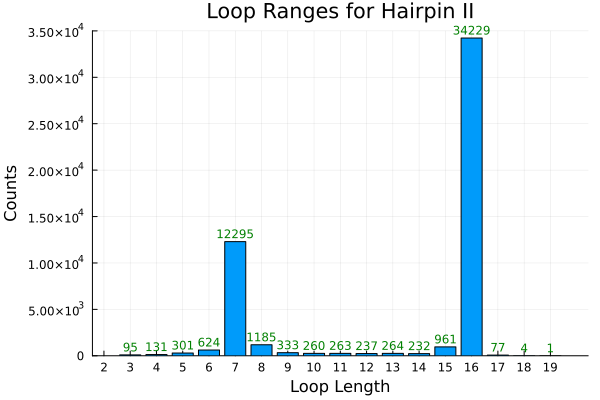

In [51]:
#using Plots


# Extract keys and values from the dictionary
entries = collect(keys(Loop_ranges))
counts = collect(values(Loop_ranges))

# Create bar plot
bar(entries, counts, xlabel="Loop Length", ylabel="Counts", title="Loop Ranges for Hairpin II",ylim=(0, 35000), xticks = 0:1:(length(entries)+2),legend = false)

# Annotate the plot with counts
for i in 1:length(entries)
    annotate!(entries[i], counts[i] + 100, text(counts[i], :center, :bottom, 8, :green))
end

# Display the plot
hairpin_plot = plot!()
hairpin_plot

In [56]:
# saving the plot as png image
savefig(hairpin_plot,"L2_LoopRanges_plot.png")

"/Users/marlenewerner/Desktop/Diplom/Labo Work/Code for Analysis/RNA_structure_loops/L2_zmerged/L2_LoopRanges_plot.png"

#### Stem:

<a id='Stem'></a>

In [57]:
search_set_stem = []
for n = 1: 20
    wt_pre = "4-2-"
    wt_loop = "-7-"
    wt_pos = "-2-4"
    
    new_item = wt_pre * "$(n)" * wt_loop * "$(n)" * wt_pos
    push!(search_set_stem, new_item)
end
search_set_stem

20-element Vector{Any}:
 "4-2-1-7-1-2-4"
 "4-2-2-7-2-2-4"
 "4-2-3-7-3-2-4"
 "4-2-4-7-4-2-4"
 "4-2-5-7-5-2-4"
 "4-2-6-7-6-2-4"
 "4-2-7-7-7-2-4"
 "4-2-8-7-8-2-4"
 "4-2-9-7-9-2-4"
 "4-2-10-7-10-2-4"
 "4-2-11-7-11-2-4"
 "4-2-12-7-12-2-4"
 "4-2-13-7-13-2-4"
 "4-2-14-7-14-2-4"
 "4-2-15-7-15-2-4"
 "4-2-16-7-16-2-4"
 "4-2-17-7-17-2-4"
 "4-2-18-7-18-2-4"
 "4-2-19-7-19-2-4"
 "4-2-20-7-20-2-4"

In [58]:
ForStemAnalysis = filter(:Loop2_description => n -> n ∈ search_set_stem, lib_L2_StructureAnalysis)
sort!(ForStemAnalysis, [:MFE_energy, :Mbp_dist])

Row,Sequence_number,Loop2_description,MFE_SUBstructure,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,String15
1,80417,4-2-9-7-9-2-4,((((..(((((((((.......)))))))))..)))),CCGGATCAAGAGTAGTGTTTCTGGCTACTCTTTTTCCGA,39,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((((.......)))))))))..))))...((((.(((((((.....)))).))).)))).........,-48.5,5.42629,L2L_80417
2,55818,4-2-9-7-9-2-4,((((..(((((((((.......)))))))))..)))),CCGGATCAAGAGTCGCGTCTGGGGTGACTCTTTTTCCGA,39,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((((.......)))))))))..))))...((((.(((((((.....)))).))).)))).........,-48.0,5.60348,L2L_55818
3,53779,4-2-7-7-7-2-4,((((..(((((((.......)))))))..)))),CCGGATCAAGAGTGGAGAGTACACTCTTTTTCCGA,35,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((.......)))))))..))))...((((.(((((((.....)))).))).)))).........,-46.8,5.33901,L2L_53779
4,30783,4-2-9-7-9-2-4,((((..(((((((((.......)))))))))..)))),CCGGATCAAGAGTGGCCACGGCAGTTACTCTTTTTCCGA,39,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((((.......)))))))))..))))...((((.(((((((.....)))).))).)))).........,-46.7,5.42737,L2L_30783
5,55033,4-2-9-7-9-2-4,((((..(((((((((.......)))))))))..)))),CCGGATCAAGAGTCGATCGACCCTTGACTCTTTTTCCGA,39,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((((.......)))))))))..))))...((((.(((((((.....)))).))).)))).........,-46.7,6.18419,L2L_55033
6,77018,4-2-9-7-9-2-4,((((..(((((((((.......)))))))))..)))),CCGGATCAAGAGTAGGCCCTTATCTTACTCTTTTTCCGA,39,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((((.......)))))))))..))))...((((.(((((((.....)))).))).)))).........,-46.6,5.51164,L2L_77018
7,71689,4-2-8-7-8-2-4,((((..((((((((.......))))))))..)))),CCGGATCAAGAGTGGTTTACGTCTACTCTTTTTCCGA,37,1,false,.((((.((((((((((.....)))))))))).))))..((((..((((((((.......))))))))..))))...((((.(((((((.....)))).))).)))).........,-46.4,5.37337,L2L_71689
8,14959,4-2-7-7-7-2-4,((((..(((((((.......)))))))..)))),CCGGATCAAGAGTCTACATCCGACTCTTTTTCCGA,35,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((.......)))))))..))))...((((.(((((((.....)))).))).)))).........,-46.0,5.34512,L2L_14959
9,67674,4-2-7-7-7-2-4,((((..(((((((.......)))))))..)))),CCGGATCAAGAGTCTCAAGACGACTCTTTTTCCGA,35,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((.......)))))))..))))...((((.(((((((.....)))).))).)))).........,-46.0,5.35843,L2L_67674


In [59]:
## sorting the structures with relative similarity by their actual Loop2_description
StemSame_structure = []
for structure in ForStemAnalysis.MFE_SUBstructure
    if structure ∉ StemSame_structure && structure != L2_WT_pattern
        push!(StemSame_structure, structure)
    end
end
StemSame_structure

8-element Vector{Any}:
 "((((..(((((((((.......)))))))))..))))"
 "((((..(((((((.......)))))))..))))"
 "((((..((((((((.......))))))))..))))"
 "((((..((((((.......))))))..))))"
 "((((..(((((.......)))))..))))"
 "((((..((((.......))))..))))"
 "((((..(((.......)))..))))"
 "((((..((.......))..))))"

In [60]:
## getting an overview on the stem sizes of the hairpin structures
x_values = find_x_values(ForStemAnalysis.Loop2_description)

println("Range of Stem bases:")
println(sort!(collect(x_values)))



Range of Stem bases:
[2, 3, 4, 5, 6, 7, 8, 9]


In [61]:
Stem_ranges = Dict{Int64,Int64}()
for num in sort!(collect(x_values))
    Loop2_desc = "4-2-$(num)-7-$(num)-2-4"
    seq_dataframe = filter(:Loop2_description => n -> n == Loop2_desc, lib_L2_StructureAnalysis)
    
     # Sum of the counts of each Sequence with the set hairpin description
    count_seq = 0
    for m = 1:nrow(seq_dataframe)
        count_seq += seq_dataframe.Count[m]
    end
    
    Stem_ranges[num] = count_seq
end
Stem_ranges

Dict{Int64, Int64} with 8 entries:
  5 => 12295
  4 => 26
  6 => 57
  7 => 26
  2 => 2
  9 => 11
  8 => 3
  3 => 20

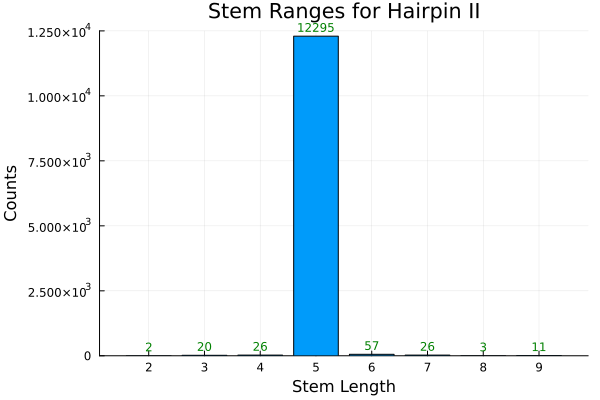

In [62]:
# Extract keys and values from the dictionary
entries = collect(keys(Stem_ranges))
counts = collect(values(Stem_ranges))

# Create bar plot
bar(entries, counts, xlabel="Stem Length", ylabel="Counts", title="Stem Ranges for Hairpin II",  xticks = 0:1:(length(entries)+5), ylim=(0, 12500), legend = false)

# Annotate the plot with counts
for i in 1:length(entries)
    annotate!(entries[i], counts[i] + 70, text(counts[i], :center, :bottom, 8, :green))
end

# Display the plot
hairpin_plot = plot!()
hairpin_plot

In [63]:
# saving the plot as png image
savefig(hairpin_plot,"L2_StemRanges_plot.png")

"/Users/marlenewerner/Desktop/Diplom/Labo Work/Code for Analysis/RNA_structure_loops/L2_zmerged/L2_StemRanges_plot.png"

### Filtering Sequences for Viability tests

<a id='filtering'></a>

In [31]:
using DataFrames
using CSV

function nucleotide_difference(sequence1::String, sequence2::String)
    return sum(a != b for (a, b) in zip(sequence1, sequence2))
end

function combine_identical_sequences(sequences::Vector{String}, counts::Vector{Int})
    n = length(sequences)
    
    # Create a dictionary to store cumulative counts for identical sequences
    cumulative_counts = Dict{String, Int}()
    
    for i in 1:n
        current_sequence = sequences[i]
        if haskey(cumulative_counts, current_sequence)
            cumulative_counts[current_sequence] += counts[i]
        else
            cumulative_counts[current_sequence] = counts[i]
        end
    end
    
    # Create a new DataFrame with combined sequences and counts
    combined_df = DataFrame(Sequence = [], Count = [])
    
    for (sequence, count) in pairs(cumulative_counts)
        push!(combined_df, [sequence, count])
    end
    
    return combined_df
end

function cluster_sequences_by_difference_and_count(sequences::Vector, difference_threshold::Int, structure::String, original_counts::Vector)
    n = length(sequences)
    
    # Create a DataFrame to store the sequences and their original counts
    count_df = DataFrame(Sequence = sequences, Count = original_counts)
    
    # Sort sequences by count in descending order
    sort!(count_df, [:Count, :Sequence], rev=[true, false])
    
    # Initialize the current cluster ID
    current_cluster = 0
    
    # Initialize an array to store the cluster assignment for each sequence
    clusters = zeros(Int, n)
    
    for i in 1:n
        # If the current sequence is not assigned to any cluster, create a new cluster
        if clusters[i] == 0
            current_cluster += 1
            clusters[i] = current_cluster
            
            # Find sequences with the specified difference threshold and assign them to the same cluster
            for j in (i+1):n
                if clusters[j] == 0 && nucleotide_difference(sequences[i], sequences[j]) <= difference_threshold
                    clusters[j] = clusters[i]
                end
            end
        end
    end
    
    # Create a DataFrame to store the clustering result
    df = DataFrame(LoopI_description = fill(structure, n), Sequence = sequences, Count = original_counts, Cluster = clusters)

    # Create a count table
    count_table = combine(groupby(df, [:Cluster, :Sequence]), nrow)

    # Write count table to CSV
    CSV.write("$(structure)_count_table.csv", count_table)

    # Iterate over clusters and write sequences to FASTA files
    for cluster_id in 1:maximum(clusters)
        cluster_sequences = df[df.Cluster .== cluster_id, :].Sequence
        fasta_content = join(">sequence_$i\n$s\n" for (i, s) in enumerate(cluster_sequences))
        #write("$(structure)_dif$(difference_threshold)_cluster_$cluster_id.fasta", fasta_content)
    end

    return count_df, df, count_table
end

cluster_sequences_by_difference_and_count (generic function with 1 method)

In [32]:
Structure = "4-2-5-10-5-2-4"
LongestLoopAnalysis = filter(:Loop2_description => n -> n == Structure, lib_L2_StructureAnalysis)
sort!(LongestLoopAnalysis, [:Count])

# Replace this with your actual sequence data and counts
sequences = LongestLoopAnalysis.LoopII
original_counts = LongestLoopAnalysis.Count

# Combine identical sequences and sum their counts
combined_df = sort!(combine_identical_sequences(sequences, original_counts), :Count, rev = true)

# Replace this with your actual sequence data and counts
combined_sequences = combined_df.Sequence
counts = combined_df.Count

# Set the threshold for clustering based on nucleotide differences
difference_threshold = 2

# Cluster the sequences, create FASTA files, and generate count table
count_df, result_df, count_table = cluster_sequences_by_difference_and_count(combined_sequences, difference_threshold, Structure, counts)

# Display the DataFrame and count table

#@show(count_df)
#show(sort!(result_df, [:Cluster, :Count]), allcols=true)

display(count_table)

using PrettyTables

# Calculate the number of sequences per cluster
cluster_counts = combine(groupby(result_df, :Cluster), :Count => sum => :Total_Count)

# Sort the table by total count in descending order
cluster_counts = sort(cluster_counts, :Total_Count, rev=true)

# Display the table
pretty_table(cluster_counts, crop=:vertical)

####new


# Iterate over clusters and display tables for counts per sequence
#for cluster_id in maximum(result_df.Cluster)
 #   cluster_name = "Cluster $cluster_id"
  #  cluster_sequences_table = result_df[result_df.Cluster .== cluster_id, [:Sequence, :Count]]
   # println("\n$cluster_name:")
    #pretty_table(cluster_sequences_table, crop=:none)
#end


count = 0
for entry in eachrow(cluster_counts)
    count += 1
    if count <= 5
        cluster_id = entry.Cluster
        cluster_name = "Cluster $cluster_id"
        cluster_sequences_table = result_df[result_df.Cluster .== cluster_id, [:Sequence, :Count]]
        println("\n$cluster_name:")
        pretty_table(cluster_sequences_table, crop=:none)
        
        cluster_sequences = result_df[result_df.Cluster .== cluster_id, :].Sequence
        fasta_content = join(">sequence_$i\n$s\n" for (i, s) in enumerate(cluster_sequences))
        write("$(Structure)_dif$(difference_threshold)_cluster_$cluster_id.fasta", fasta_content)
    else 
        break
    end
end


Row,Cluster,Sequence,nrow
,Int64,Any,Int64
1,1,CCGGATCAAGAGGTATAAGGCACTCTTTTTCCGA,1
2,2,CCGGATCAAGAGCAAGTGGTTACTCTTTTTCCGA,1
3,3,CCGGATCAAGAGGCGGGGGTCACTCTTTTTCCGA,1
4,4,CCGGATCAAGAGGTAACGTCGACTCTTTTTCCGA,1
5,5,CCGGATCAAGAGGTAGGTATGACTCTTTTTCCGA,1
6,6,CCGGATCAAGAGGTAGGATCGACTCTTTTTCCGA,1
7,7,CCGGATCAAGAGGTAGGGGGCACTCTTTTTCCGA,1
8,8,CCGGATCAAGAGCCTGTTGCAACTCTTTTTCCGA,1
9,9,CCGGATCAAGAGCAGTACCAAACTCTTTTTCCGA,1


┌─────────┬─────────────┐
│ Cluster │ Total_Count │
│   Int64 │       Int64 │
├─────────┼─────────────┤
│       1 │           4 │
│       6 │           4 │
│      29 │           4 │
│       3 │           3 │
│       8 │           3 │
│      34 │           3 │
│      48 │           3 │
│      54 │           3 │
│      74 │           3 │
│      83 │           3 │
│      96 │           3 │
│     135 │           3 │
│       2 │           2 │
│       7 │           2 │
│      16 │           2 │
│      20 │           2 │
│      21 │           2 │
│      26 │           2 │
│      30 │           2 │
│      39 │           2 │
│      52 │           2 │
│    ⋮    │      ⋮      │
└─────────┴─────────────┘
         185 rows omitted

Cluster 1:
┌────────────────────────────────────┬───────┐
│                           Sequence │ Count │
│                                Any │   Any │
├────────────────────────────────────┼───────┤
│ CCGGATCAAGAGGTATAAGGCACTCTTTTTCCGA │     2 │
│ CCGGATCAAGAGGTACTAGGCAC

In [33]:
#number = "L1L1_30443"
#getSeq = filter(:Lib_Sequence_number => n -> n == number, lib_L2_StructureAnalysis)
#getSeq
# Load FASTA file as an Array of String
function load_fasta_file(file_name::String)
    R0 = []
    reader = FASTA.Reader(open(file_name, "r"))
    for record in reader
        push!(R0, convert(String, FASTA.sequence(record)))
    end
    close(reader)
    return R0
end


# Replace "your_file.fasta" with the actual path to your FASTA file
fasta_file_path1 = "4-2-5-18-5-2-4_dif4_cluster_1.fasta"
sequences1 = load_fasta_file(fasta_file_path1)

fasta_file_path2 = "4-2-5-18-5-2-4_dif4_cluster_2.fasta"
sequences2 = load_fasta_file(fasta_file_path2)

fasta_file_path3 = "4-2-5-18-5-2-4_dif4_cluster_3.fasta"
sequences3 = load_fasta_file(fasta_file_path3)

fasta_file_path4 = "4-2-5-18-5-2-4_dif4_cluster_4.fasta"
sequences4 = load_fasta_file(fasta_file_path4)


Seq = vcat(sequences1, sequences2, sequences3, sequences4)
Top3Clusters = filter(:LoopII => n -> n ∈ Seq, lib_L2_StructureAnalysis)
sort!(Top3Clusters, [:MFE_energy])
display(Top3Clusters)



save_name = "L2_5-18-5_top3Clusters" * ".csv"

## Saving results
CSV.write(save_name, Top3Clusters)



Row,Sequence_number,Loop2_description,MFE_SUBstructure,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,String15
1,32260,4-2-5-18-5-2-4,((((..(((((..................)))))..)))),CCGGATCAAGAGGTCAGCCGTGTGAACTAACTCTTTTTCCGA,42,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((..................)))))..))))...((((.(((((((.....)))).))).)))).........,-42.5,6.4256,L2L_32260
2,54567,4-2-5-18-5-2-4,((((..(((((..................)))))..)))),CCGGATCAAGAGGGACGTTCTTTGAATGAACTCTTTTTCCGA,42,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((..................)))))..))))...((((.(((((((.....)))).))).)))).........,-42.5,9.30008,L2L_54567
3,62466,4-2-5-18-5-2-4,((((..(((((..................)))))..)))),CCGGATCAAGAGGGTATTGGTCTTGGTGCACTCTTTTTCCGA,42,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((..................)))))..))))...((((.(((((((.....)))).))).)))).........,-42.5,9.11334,L2L_62466
4,29658,4-2-5-18-5-2-4,((((..(((((..................)))))..)))),CCGGATCAAGAGCCTCTTGCAACTCCTATACTCTTTTTCCGA,42,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((..................)))))..))))...((((.(((((((.....)))).))).)))).........,-41.1,5.43392,L2L_29658


"L2_5-18-5_top3Clusters.csv"

In [34]:
Thr3_cluster = load_fasta_file("$(Structure)_dif3_cluster_1797.fasta");
Thr2_cluster = load_fasta_file("$(Structure)_dif2_cluster_4620.fasta");

# Find the common elements
common_sequences = intersect(Thr2_cluster, Thr3_cluster)

# Check if there are common sequences
if isempty(common_sequences)
    println("No common sequences.")
else
    println("Common sequences: ", common_sequences)
end

LoadError: SystemError: opening file "4-2-5-10-5-2-4_dif3_cluster_1797.fasta": No such file or directory

In [35]:
structure = "4-2-9-7-9-2-4"
PickbyEnergy = filter(:Loop2_description => n -> n == structure, lib_L2_StructureAnalysis)
sort!(PickbyEnergy, [:MFE_energy])
#sort!(PickbyEnergy, [:Sequence_number])
display(PickbyEnergy)

save_name = "4-2-9-7-9-2-4_EnergyPick" * ".csv"

## Saving results
CSV.write(save_name, PickbyEnergy)

Row,Sequence_number,Loop2_description,MFE_SUBstructure,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,String15
1,80417,4-2-9-7-9-2-4,((((..(((((((((.......)))))))))..)))),CCGGATCAAGAGTAGTGTTTCTGGCTACTCTTTTTCCGA,39,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((((.......)))))))))..))))...((((.(((((((.....)))).))).)))).........,-48.5,5.42629,L2L_80417
2,55818,4-2-9-7-9-2-4,((((..(((((((((.......)))))))))..)))),CCGGATCAAGAGTCGCGTCTGGGGTGACTCTTTTTCCGA,39,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((((.......)))))))))..))))...((((.(((((((.....)))).))).)))).........,-48.0,5.60348,L2L_55818
3,30783,4-2-9-7-9-2-4,((((..(((((((((.......)))))))))..)))),CCGGATCAAGAGTGGCCACGGCAGTTACTCTTTTTCCGA,39,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((((.......)))))))))..))))...((((.(((((((.....)))).))).)))).........,-46.7,5.42737,L2L_30783
4,55033,4-2-9-7-9-2-4,((((..(((((((((.......)))))))))..)))),CCGGATCAAGAGTCGATCGACCCTTGACTCTTTTTCCGA,39,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((((.......)))))))))..))))...((((.(((((((.....)))).))).)))).........,-46.7,6.18419,L2L_55033
5,77018,4-2-9-7-9-2-4,((((..(((((((((.......)))))))))..)))),CCGGATCAAGAGTAGGCCCTTATCTTACTCTTTTTCCGA,39,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((((.......)))))))))..))))...((((.(((((((.....)))).))).)))).........,-46.6,5.51164,L2L_77018
6,39359,4-2-9-7-9-2-4,((((..(((((((((.......)))))))))..)))),CCGGATCAAGAGTGGATTCTGGTTTTACTCTTTTTCCGA,39,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((((.......)))))))))..))))...((((.(((((((.....)))).))).)))).........,-45.7,5.56096,L2L_39359
7,62421,4-2-9-7-9-2-4,((((..(((((((((.......)))))))))..)))),CCGGATCAAGAGTAGATTCGACGTTTACTCTTTTTCCGA,39,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((((.......)))))))))..))))...((((.(((((((.....)))).))).)))).........,-45.7,6.08926,L2L_62421
8,28926,4-2-9-7-9-2-4,((((..(((((((((.......)))))))))..)))),CCGGATCAAGAGTTGGTTGTCAGTTAACTCTTTTTCCGA,39,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((((.......)))))))))..))))...((((.(((((((.....)))).))).)))).........,-44.5,6.26021,L2L_28926
9,58442,4-2-9-7-9-2-4,((((..(((((((((.......)))))))))..)))),CCGGATCAAGAGTTGGTGAATCGTTAACTCTTTTTCCGA,39,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((((((.......)))))))))..))))...((((.(((((((.....)))).))).)))).........,-44.5,6.32939,L2L_58442


"4-2-9-7-9-2-4_EnergyPick.csv"

In [50]:
seq = "L2L_62804"
PickbyEnergy = filter(:Lib_Sequence_number => n -> n == seq, lib_L2_StructureAnalysis)
#sort!(PickbyEnergy, [:MFE_energy])
#sort!(PickbyEnergy, [:Sequence_number])

Row,Sequence_number,Loop2_description,MFE_SUBstructure,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,String15
1,62804,4-2-5-16-5-2-4,((((..(((((................)))))..)))),CCGGATCAAGAGATTTTGTATCTATTCACTCTTTTTCCGA,40,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((................)))))..))))...((((.(((((((.....)))).))).)))).........,-41.1,5.87682,L2L_62804


In [37]:
seq = "CCGGATCAAGAGCCACTATTCACTCTTTTTCCGA"
PickbyEnergy = filter(:LoopII => n -> n == seq, lib_L2_StructureAnalysis)

Row,Sequence_number,Loop2_description,MFE_SUBstructure,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,String15
1,64208,4-2-5-10-5-2-4,((((..(((((..........)))))..)))),CCGGATCAAGAGCCACTATTCACTCTTTTTCCGA,34,1,false,.((((.((((((((((.....)))))))))).))))..((((..(((((..........)))))..))))...((((.(((((((.....)))).))).)))).........,-41.1,5.36748,L2L_64208


## Analysis of Hairpin quantity

In [3]:
## Convenient place to safe the resulting dataframe for easy accessibilty

save_name = "lib_L2_StructureAnalysis" * ".csv"


## Saving results
#CSV.write(save_name, lib_L2_StructureAnalysis)

## Opening saved results
lib_L2_StructureAnalysis = CSV.read(save_name, DataFrame);

In [4]:
function hairpin_finder(dataset::DataFrame)
    
    HPCounts = DataFrame([[], []], ["Lib_Sequence_number", "Hairpin_count"])
    for n = 1: size(dataset, 1)
        
        structure = dataset.MFE_structure[n]
        ID = dataset.Lib_Sequence_number[n]

        openHP = false
        dot = false
        closeHP = false

        hairpin_count = 0

        for n = 1:length(structure)
            if structure[n] == '(' && !openHP
                openHP = true
            elseif structure[n] == '(' && openHP
                continue
            elseif structure[n] == '.' && !dot
                dot = true
            elseif structure[n] == '.' && dot
                continue
            elseif structure[n] == ')' && !closeHP
                closeHP = true
            elseif structure[n] == ')' && closeHP && openHP && dot
                hairpin_count += 1
                openHP = false
                dot = false
                closeHP = false
            elseif structure[n] == ')' && closeHP
                continue
            end
        end
        
        push!(HPCounts, (ID, hairpin_count))
    end

    return HPCounts
end


hairpin_finder (generic function with 1 method)

In [5]:
hpCounts = hairpin_finder(lib_L2_StructureAnalysis)

Row,Lib_Sequence_number,Hairpin_count
,Any,Any
1,L2L_1,3
2,L2L_2,3
3,L2L_3,3
4,L2L_4,3
5,L2L_5,3
6,L2L_6,3
7,L2L_7,3
8,L2L_8,3
9,L2L_9,3


In [18]:
Loop2_StructureAnalysis = innerjoin(lib_L2_StructureAnalysis, hpCounts, on = :Lib_Sequence_number)

Row,Sequence_number,Loop2_description,MFE_SUBstructure,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number,Hairpin_count
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,String15,Any
1,1,4-2-5-7-5-2-4,((((..(((((.......)))))..)))),CCGGATCAAGAGCTACCAACTCTTTTTCCGA,31,1419,false,.((((.((((((((((.....)))))))))).))))..((((..(((((.......)))))..))))...((((.(((((((.....)))).))).)))).........,-41.1,5.39571,L2L_1,3
2,2,4-2-3-4-3-2-4,((((..(((....)))..)))),CCGGATCAAGAGCTCTTTTTCCGA,24,114,false,.((((.((((((((((.....)))))))))).))))..((((..(((....)))..))))...((((.(((((((.....)))).))).)))).........,-37.0,5.65155,L2L_2,3
3,3,4-13-4,((((.............)))),CCGGATCAAGAGTCTTTTTCCGA,23,94,false,.((((.((((((((((.....)))))))))).))))..((((.............))))...((((.(((((((.....)))).))).)))).........,-35.4,6.23822,L2L_3,3
4,4,4-2-3-5-3-2-4,((((..(((.....)))..)))),CCGGATCAAGAGACTCTTTTTCCGA,25,83,false,.((((.((((((((((.....)))))))))).))))..((((..(((.....)))..))))...((((.(((((((.....)))).))).)))).........,-37.0,5.95504,L2L_4,3
5,5,4-12-4,((((............)))),CCGGATCAAGAGCTTTTTCCGA,22,58,false,.((((.((((((((((.....)))))))))).))))..((((............))))...((((.(((((((.....)))).))).)))).........,-35.4,5.42139,L2L_5,3
6,6,4-2-4-4-4-2-4,((((..((((....))))..)))),CCGGATCAAGAGGACTCTTTTTCCGA,26,42,false,.((((.((((((((((.....)))))))))).))))..((((..((((....))))..))))...((((.(((((((.....)))).))).)))).........,-38.4,5.91392,L2L_6,3
7,7,4-2-4-4-4-2-4,((((..((((....))))..)))),CCGGATCAAGAGAACTCTTTTTCCGA,26,23,false,.((((.((((((((((.....)))))))))).))))..((((..((((....))))..))))...((((.(((((((.....)))).))).)))).........,-38.4,5.90996,L2L_7,3
8,8,4-2-5-4-5-2-4,((((..(((((....)))))..)))),CCGGATCAAGAGGGCACTCTTTTTCCGA,28,22,false,.((((.((((((((((.....)))))))))).))))..((((..(((((....)))))..))))...((((.(((((((.....)))).))).)))).........,-42.5,5.52285,L2L_8,3
9,9,4-2-5-5-5-2-4,((((..(((((.....)))))..)))),CCGGATCAAGAGAGGGACTCTTTTTCCGA,29,22,false,.((((.((((((((((.....)))))))))).))))..((((..(((((.....)))))..))))...((((.(((((((.....)))).))).)))).........,-41.1,5.66446,L2L_9,3


In [7]:
file_name = "Loop2_Analysis_mw.fasta"

"Loop2_Analysis_mw.fasta"

In [8]:
save_name = "CountedHP" * file_name[1:end-6] * ".csv"


## Saving results
#CSV.write(save_name, Loop2_StructureAnalysis)

## Opening saved results
#save_name = "StructureAnalysisReady_Old_large_Loop1_rc.csv"
Loop2_StructureAnalysis = CSV.read(save_name, DataFrame);

In [9]:
## getting an overview on the range of the amount of hairpins
HPcounts = Loop2_StructureAnalysis.Hairpin_count
HPrange = sort!(unique(HPcounts))

println("Range of hairpins:")
println(HPrange)

HPdistribution = Dict{Int64,Int64}()
for num in HPcounts
    seq_dataframe = filter(:Hairpin_count => n -> n == num, Loop2_StructureAnalysis)
    count_seq = nrow(seq_dataframe)
    HPdistribution[num] = count_seq
end
HPdistribution

Range of hairpins:
[2, 3, 4, 5, 6, 7]


Dict{Int64, Int64} with 6 entries:
  5 => 88
  4 => 3953
  6 => 11
  7 => 1
  2 => 825
  3 => 191192

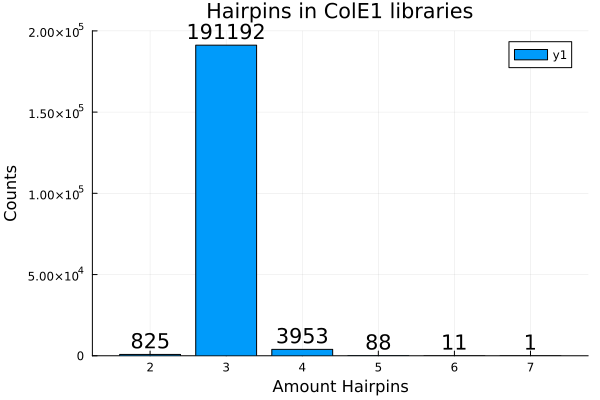

In [10]:
# Extract keys and values from the dictionary
entries = collect(keys(HPdistribution))
counts = collect(values(HPdistribution))

# Create bar plot
bar(entries, counts, xlabel="Amount Hairpins", ylabel="Counts", title="Hairpins in ColE1 libraries",  xticks = 0:1:(length(entries)+5), ylim=(0, 200000))

# Annotate the plot with counts
for i in 1:length(entries)
    annotate!(entries[i], counts[i] + 1000, text(counts[i], :center, :bottom))
end

# Display the plot
hairpin_plot = plot!()
hairpin_plot

In [12]:
savefig(hairpin_plot,"L2_hpAmounts_plot.png")

"/Users/marlenewerner/Desktop/Diplom/Labo Work/Code for Analysis/RNA_structure_loops/L2_zmerged/L2_hpAmounts_plot.png"

In [11]:
coolHPs = filter(:Hairpin_count => n -> n != 3 , Loop2_StructureAnalysis)
sort!(coolHPs, [:Mbp_dist])

Row,Sequence_number,Loop2_description,MFE_SUBstructure,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number,Hairpin_count
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,String15,Any
1,64739,1-5-1-4-3-10-3-2-1,.(((((.((((...((((((((((...((.,CCGGATCATGCGGTATGTTGAGGTTTTTCCGA,32,1,false,.((((.((((((((((.....)))))))))).))))...(((((.((((...((((((((((...((....)).....))))))))))...))))))).)).........,-44.5,3.11577,L2M_64739,2
2,46289,1-5-1-2-2-5-2-4-5-2-1,.(((((.((..(((((..((((.....((.,CCGGATCAGCTGTCTGTTTGCCATTTTTCCGA,32,1,false,.((((.((((((((((.....)))))))))).))))...(((((.((..(((((..((((.....((....))....))))....)))))..)).))).)).........,-40.5,3.1938,L2M_46289,2
3,70918,1-5-1-9-1-7-3-2-1,.(((((.(((((((((.(((((((...((.,CCGGATCAGTGTTTTGTATGAGGTCTTTCCGA,32,1,false,.((((.((((((((((.....)))))))))).))))...(((((.(((((((((.(((((((...((....)).....)))))))))))))))).))).)).........,-41.0,3.1967,L2M_70918,2
4,5990,1-5-3-7-3-2-6-2-1,.(((((...(((((((...((......((.,CCGGATCAGAGTTCTGCGCTGCATTTTTCCGA,32,1,false,.((((.((((((((((.....)))))))))).))))...(((((...(((((((...((......((....))......))....)))))))...))).)).........,-41.2,3.25972,L2M_5990,2
5,18639,1-5-2-3-4-8-4-2-1,.(((((..(((....((((((((....((.,CCGGATCAACGTGTATCTGAGGCTTTTTCCGA,32,1,false,.((((.((((((((((.....)))))))))).))))...(((((..(((....((((((((....((....)).....))))))))....)))..))).)).........,-41.3,3.2812,L2M_18639,2
6,74431,1-5-1-11-1-3-5-2-1,.(((((.(((((((((((.(((.....((.,CCGGATCAGCCTCTGTTGATGTTTTTTTCCGA,32,1,false,.((((.((((((((((.....)))))))))).))))...(((((.(((((((((((.(((.....((....)).....))).))))))))).)).))).)).........,-42.8,3.3408,L2M_74431,2
7,73662,1-5-2-3-2-8-6-2-1,.(((((..(((..((((((((......((.,CCGGATCAGGCGAGGCTGAGGTGTTTTTCCGA,32,1,false,.((((.((((((((((.....)))))))))).))))...(((((..(((..((((((((......((....))......))))))))....))).))).)).........,-44.0,3.49624,L2M_73662,2
8,28642,1-5-1-2-1-14-3-2-1,.(((((.((.((((((((((((((...((.,CCGGATCAGCTGTTCTGTTGGGGTTTTTCCGA,32,1,false,.((((.((((((((((.....)))))))))).))))...(((((.((.((((((((((((((...((....)).....)))))))))))))))).))).)).........,-44.1,3.50267,L2M_28642,2
9,36975,1-7-2-1-6-2-3-4-3-1,(.......)).))))))..(((....))).,CCGGATCAAGGAGTAAACCAGGATTTTTCCGA,32,1,false,(((...((((((((((.....))))))))))((((((((.......)).))))))..(((....)))....((((.(((((((.....)))).))).))))......))),-40.6,3.55788,L2M_36975,4


In [12]:
save_name = "InterestingHP" * file_name[1:end-6] * ".csv"


## Saving results
CSV.write(save_name, coolHPs)

## Opening saved results
#save_name = "StructureAnalysisReady_Old_large_Loop1_rc.csv"
Loop2_CountedHPAnalysis = CSV.read(save_name, DataFrame);

In [13]:
# filtering for Sequences with 1,5,6 or 7 hairpins in predicted structure
searchSet_hp = [1, 5, 6, 7]
extremeHP = filter(:Hairpin_count => n -> n ∈ searchSet_hp , Loop2_StructureAnalysis)
sort!(extremeHP, [:Mbp_dist])

Row,Sequence_number,Loop2_description,MFE_SUBstructure,LoopII,Loop_length,Count,WT,MFE_structure,MFE_energy,Mbp_dist,Lib_Sequence_number,Hairpin_count
,Int64,String,String,String,Int64,Int64,String7,String,Float64,Float64,String15,Int64
1,65363,1-9-8-3-4-3-2-7-1,(.........))))))))(((....)))((.......),CCGGATCAAGAGGGCAAACGTCATGAGACTCTTTTTCCGA,40,1,false,(((...((((((((((.....))))))))))((((((((.........))))))))(((....)))((.......))..((((.(((((((.....)))).))).))))......))),-47.1,5.72253,L2L_65363,5
2,76508,2-10-5-3-3-3-2-2-7-1,((..........)))))(((...)))..((.......),CCGGATCAAGAGACGGGCGCCGATGGCACTCTTTTTCCGA,40,1,false,(((...((((((((((.....))))))))))....(((((..........)))))(((...)))..((.......))..((((.(((((((.....)))).))).))))......))),-43.6,7.9219,L2L_76508,5
3,27638,1-9-4-2-4-2-5-7-4,(.........))))((....))(((((.......)))),CCGGATCAAGAGGGCTCTGATGATCGGACTCTTTTTCCGA,40,1,false,(((...((((((((((.....))))))))))....((((.........))))((....))(((((.......)))))..((((.(((((((.....)))).))).))))......))),-44.8,8.04123,L2L_27638,5
4,15914,1-9-8-3-4-3-2-7-1,(.........))))))))(((....)))((.......),CCGGATCAAGAGGGCAAACGTTTTTAGACTCTTTTTCCGA,40,1,false,(((...((((((((((.....))))))))))((((((((.........))))))))(((....)))((.......))..((((.(((((((.....)))).))).))))......))),-44.7,8.5143,L2L_15914,5
5,58288,1-7-4-3-5-3-1-3-7-3-1,(.......))))(((.....))).(((.......))).,CCGGATCAAGGGCCAGTGATTCTGAGGACTCTTTTTCCGA,40,1,false,(((...((((((((((.....))))))))))....((((.......))))(((.....))).(((.......)))....((((.(((((((.....)))).))).))))......))),-43.8,8.63636,L2L_58288,5
6,70501,1-9-4-5-4-5-2-7-1,(.........))))(((((....)))))((.......),CCGGATCAAGAGGGCGTGCTCAATGGCACTCTTTTTCCGA,40,1,false,(((...((((((((((.....))))))))))....((((.........))))(((((....)))))((.......))..((((.(((((((.....)))).))).))))......))),-44.9,9.08022,L2L_70501,5
7,15447,3-1-2-4-8-3-4-3-2-7-1,(((.((....))))))))(((....)))((.......),CCGGATCAAGAGACCGGGTGTGATTTCACTCTTTTTCCGA,40,1,false,(((...((((((((((.....))))))))))....((((((.((....))))))))(((....)))((.......))..((((.(((((((.....)))).))).))))......))),-43.2,9.31902,L2L_15447,5
8,23267,16-5-9-1-3-6-4-8-4-6-3-1-3-2-6-4-18-4-3-3-7-36-3-11-1-4-1-4-22-4,((((((((((((((((.....(((((((((.(((......((((........))))......))).)))..))))))((((..................))))...(((.......))))))))))))))))))))))))))))))))))))...))))))))))).)))).((((......................)))),CAAGCAGCAGATTACGCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACAAGGAGACATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAAAAAAAAAGCTATGCACAAACACTGCGCGTAATCTGCTGCTTGCAAACAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAGTTCAATAGTTTTTATTTTTCCGA,204,1,false,.((((.(((((((((((...(((((((((((((((((.((((((((((((((((.....(((((((((.(((......((((........))))......))).)))..))))))((((..................))))...(((.......))))))))))))))))))))))))))))))))))))...))))))))))).)))).((((......................))))...((((.(((((((.....)))).))).)))).........,-124.5,9.57506,L2M_23267,5
9,79763,1-9-4-5-4-5-2-7-1,(.........))))(((((....)))))((.......),CCGGATCAAGAGGGCGTGCACGTCTGCACTCTTTTTCCGA,40,1,false,(((...((((((((((.....))))))))))....((((.........))))(((((....)))))((.......))..((((.(((((((.....)))).))).))))......))),-45.1,9.87636,L2L_79763,5


In [14]:
save_name = "ExtremeHP" * file_name[1:end-6] * ".csv"


## Saving results
CSV.write(save_name, extremeHP)

## Opening saved results
#save_name = "StructureAnalysisReady_Old_large_Loop1_rc.csv"
Loop1_ExtremeHPAnalysis = CSV.read(save_name, DataFrame);

### to get the full Sequence each datapoint in the dataframe, I will create a second dataframe containing this information

In [35]:
## Loops parameters
All_upstream = "CGTAATCTGCTGCTTGCAAA" #upstream Sequence of LoopI
All_downstream = "AAATACTGT" #downstream Sequence of LoopIII
wildtype = "ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA"

"ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA"

In [36]:
# Creating a dataframe with all the Sequences detected during the NGS.
Old_large_Loop_file = "/Users/marlenewerner/Desktop/Diplom/Labo Work/Code for Analysis/RNA_structure_loops/L2_long/Large_Loop2.fasta"
L_lib_pre_NGS = instance_to_count(isolate_hairpin(Old_large_Loop_file, All_upstream, All_downstream),wildtype);
L_lib_filtered_NGS = clustering_errors(L_lib_pre_NGS, wildtype, 0.005);
rename!(L_lib_filtered_NGS,:LoopI => :Loop_Sequence, :Loop_length => :Sequence_length)

Row,Sequence_number,Loop_Sequence,Sequence_length,Count,WT
,Any,Any,Any,Any,Any
1,2,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,91,79,false
2,3,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,92,68,false
3,4,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,93,53,false
4,5,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,90,48,false
5,6,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGGACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,94,23,false
6,7,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGAGGGACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,97,19,false
7,8,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGGCGGACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,97,18,false
8,9,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGGGCGACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,97,17,false
9,10,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCCCACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,96,17,false


In [37]:
# Creating a dataframe with all the Sequences detected during the NGS.
Old_medium_Loop_file = "/Users/marlenewerner/Desktop/Diplom/Labo Work/Code for Analysis/RNA_structure_loops/L2_medium/Medium_Loop2.fasta"
M_lib_pre_NGS = instance_to_count(isolate_hairpin(Old_medium_Loop_file, All_upstream, All_downstream),wildtype);
M_lib_filtered_NGS = clustering_errors(M_lib_pre_NGS, wildtype, 0.005);
rename!(M_lib_filtered_NGS,:LoopI => :Loop_Sequence, :Loop_length => :Sequence_length)

Row,Sequence_number,Loop_Sequence,Sequence_length,Count,WT
,Any,Any,Any,Any,Any
1,2,ACAAAAAAACCACAGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,99,158,false
2,3,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAGGTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,87,110,false
3,4,ACAAAAAAACCACCGCTACCATCGGTGGTTTGTTTGCCGGATCAATTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,86,46,false
4,5,ACAAAAAAACCACCGCTACCAGAGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,99,41,false
5,6,ACAAAAAAACCACCGATACCAGCGGTGGTTTGTTTGCCGGATCAATTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,86,38,false
6,7,ACAAAAAAACCACCGCTACCATCGGTGGTTTGTTTGCCGGATCAGTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,86,38,false
7,8,ACAAAAAAACCACCGCTACCAGAGGTGGTTTGTTTGCCGGATCACCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,80,37,false
8,9,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAGCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,87,37,false
9,10,ACAAAAAAACCACCGCTACCAGAGGTGGTTTGTTTGCCGGATCACTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,86,36,false


In [38]:
# Creating a dataframe with all the Sequences detected during the NGS.
Old_short_Loop_file = "/Users/marlenewerner/Desktop/Diplom/Labo Work/Code for Analysis/RNA_structure_loops/L2_short/Short_Loop2.fasta"
S_lib_pre_NGS = instance_to_count(isolate_hairpin(Old_short_Loop_file, All_upstream, All_downstream),wildtype);
S_lib_filtered_NGS = clustering_errors(S_lib_pre_NGS, wildtype, 0.005);
rename!(S_lib_filtered_NGS,:LoopI => :Loop_Sequence, :Loop_length => :Sequence_length)

Row,Sequence_number,Loop_Sequence,Sequence_length,Count,WT
,Any,Any,Any,Any,Any
1,2,ACAAAAAAACCACAGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,99,474,false
2,3,ACAAAAAAACCACCGCTACCAGCTGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,99,176,false
3,4,ACAAAAAAACCACCTCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,99,156,false
4,5,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,80,112,false
5,6,ACAAAAAAACCACCGCTACCAGAGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,99,78,false
6,7,ACAAAAAAACAACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,99,72,false
7,8,ACAAAAAAACCACCACTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,99,57,false
8,9,ACAAAAAAACCACCGCTACCATCGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,99,56,false
9,10,ACAAAAAAACCACCGCTACCAGCTGTGGTTTGTTTGCCGGATCTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,80,42,false


In [44]:
L_FullSeq_Analysis = transform!(L_lib_filtered_NGS, :Sequence_number => ByRow(number -> "HP_L2L_$number") => :Lib_Sequence_number)
M_FullSeq_Analysis = transform!(M_lib_filtered_NGS, :Sequence_number => ByRow(number -> "HP_L2M_$number") => :Lib_Sequence_number)
S_FullSeq_Analysis = transform!(S_lib_filtered_NGS, :Sequence_number => ByRow(number -> "HP_L2S_$number") => :Lib_Sequence_number)

Row,Sequence_number,Loop_Sequence,Sequence_length,Count,WT,Lib_Sequence_number
,Any,Any,Any,Any,Any,String
1,2,ACAAAAAAACCACAGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,99,474,false,HP_L2S_2
2,3,ACAAAAAAACCACCGCTACCAGCTGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,99,176,false,HP_L2S_3
3,4,ACAAAAAAACCACCTCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,99,156,false,HP_L2S_4
4,5,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,80,112,false,HP_L2S_5
5,6,ACAAAAAAACCACCGCTACCAGAGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,99,78,false,HP_L2S_6
6,7,ACAAAAAAACAACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,99,72,false,HP_L2S_7
7,8,ACAAAAAAACCACCACTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,99,57,false,HP_L2S_8
8,9,ACAAAAAAACCACCGCTACCATCGGTGGTTTGTTTGCCGGATCAAGAGCTACCAACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,99,56,false,HP_L2S_9
9,10,ACAAAAAAACCACCGCTACCAGCTGTGGTTTGTTTGCCGGATCTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,80,42,false,HP_L2S_10


In [45]:
lib_LM_StructAnalysis = vcat(L_FullSeq_Analysis, M_FullSeq_Analysis)
lib_HPStructAnalysis = vcat(lib_LM_StructAnalysis, S_FullSeq_Analysis)

Row,Sequence_number,Loop_Sequence,Sequence_length,Count,WT,Lib_Sequence_number
,Any,Any,Any,Any,Any,String
1,2,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,91,79,false,HP_L2L_2
2,3,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,92,68,false,HP_L2L_3
3,4,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,93,53,false,HP_L2L_4
4,5,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,90,48,false,HP_L2L_5
5,6,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGGACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,94,23,false,HP_L2L_6
6,7,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGAGGGACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,97,19,false,HP_L2L_7
7,8,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGGCGGACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,97,18,false,HP_L2L_8
8,9,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGGGCGACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,97,17,false,HP_L2L_9
9,10,ACAAAAAAACCACCGCTACCAGCGGTGGTTTGTTTGCCGGATCAAGAGCCCACTCTTTTTCCGAAGGTAACTGGCTTCAGCAGAGCGCAGATACCA,96,17,false,HP_L2L_10


In [46]:
## Convenient place to safe the resulting dataframe for easy accessibilty

save_name = "L2lib_HPStructAnalysis" * ".csv"


## Saving results
CSV.write(save_name, lib_HPStructAnalysis)

## Opening saved results
lib_HPStructAnalysis = CSV.read(save_name, DataFrame);